# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from itertools import product


# Configs

In [2]:
INPUT_PATH = 'data/pair_labels.parquet'

OUTPUT_PATH_TEST = 'ridge/pairs_ridge_test_predictions.parquet'
OUTPUT_PATH_TRAIN = 'ridge/pairs_ridge_train_predictions.parquet'

START_DATE = '2023-01-01'
END_DATE = '2023-04-30'

FEATURE_LIST = [
                'Previous_week_max_demand',
                'Previous_2week_max_demand',

                'Previous_2week_demand',
                'Previous_week_demand', 

                'Previous_day_demand',
                'Previous_2day_demand',
                'Previous_3day_demand',
                'Previous_4day_demand',
                'Previous_5day_demand',
                'Previous_6day_demand',
                'Previous_8day_demand',
                'Previous_9day_demand',
                'Previous_10day_demand',
                'Previous_11day_demand',
                'Previous_12day_demand',
                'Previous_13day_demand',

                'Day_of_month', 
                'Day_of_week',
                ]

VALIDATION_START_DATE = '2023-03-18'
TEST_START_DATE = '2023-04-01'

AUTO_TUNE = False

# Data preparation


## Labeling

In [3]:
labeled_df = pd.read_parquet(INPUT_PATH)

In [4]:
print(f'labeled dataframe shape : {labeled_df.shape}')
labeled_df.head()

labeled dataframe shape : (173160, 4)


,PULocation,Date,DOLocation,Demand
0,13,2023-01-01,68,20.0
1,13,2023-01-02,68,19.0
2,13,2023-01-03,68,16.0
3,13,2023-01-04,68,22.0
4,13,2023-01-05,68,31.0


## Add Feature

In [5]:
def feature_engineering(dataset):
    dataset['Previous_day_demand'] = dataset.groupby(['PULocation', 'DOLocation'])['Demand'].shift(1)
    dataset['Previous_2day_demand'] = dataset.groupby(['PULocation', 'DOLocation'])['Demand'].shift(2)
    dataset['Previous_3day_demand'] = dataset.groupby(['PULocation', 'DOLocation'])['Demand'].shift(3)
    dataset['Previous_4day_demand'] = dataset.groupby(['PULocation', 'DOLocation'])['Demand'].shift(4)
    dataset['Previous_5day_demand'] = dataset.groupby(['PULocation', 'DOLocation'])['Demand'].shift(5)
    dataset['Previous_6day_demand'] = dataset.groupby(['PULocation', 'DOLocation'])['Demand'].shift(6)
    dataset['Previous_week_demand'] = dataset.groupby(['PULocation', 'DOLocation'])['Demand'].shift(7)
    dataset['Previous_8day_demand'] = dataset.groupby(['PULocation', 'DOLocation'])['Demand'].shift(8)
    dataset['Previous_9day_demand'] = dataset.groupby(['PULocation', 'DOLocation'])['Demand'].shift(9)
    dataset['Previous_10day_demand'] = dataset.groupby(['PULocation', 'DOLocation'])['Demand'].shift(10)
    dataset['Previous_11day_demand'] = dataset.groupby(['PULocation', 'DOLocation'])['Demand'].shift(11)
    dataset['Previous_12day_demand'] = dataset.groupby(['PULocation', 'DOLocation'])['Demand'].shift(12)
    dataset['Previous_13day_demand'] = dataset.groupby(['PULocation', 'DOLocation'])['Demand'].shift(13)
    dataset['Previous_2week_demand'] = dataset.groupby(['PULocation', 'DOLocation'])['Demand'].shift(14)

    dataset['Previous_week_max_demand'] = dataset.groupby(['PULocation', 'DOLocation'])['Demand'].rolling(window=7).max().reset_index(drop = True)
    dataset['Previous_2week_max_demand'] = dataset.groupby(['PULocation', 'DOLocation'])['Demand'].rolling(window=14).max().reset_index(drop = True)

    dataset['Day_of_week'] = dataset['Date'].dt.dayofweek + 1
    dataset['Day_of_month'] = dataset['Date'].dt.day
    
    return dataset


In [6]:
features_df = feature_engineering(labeled_df)
features_df.dropna(inplace = True)

In [7]:
print(f'features dataframe shape : {features_df.shape}')
features_df.head()

features dataframe shape : (152958, 22)


,PULocation,Date,DOLocation,Demand,Previous_day_demand,Previous_2day_demand,Previous_3day_demand,Previous_4day_demand,Previous_5day_demand,Previous_6day_demand,...,Previous_9day_demand,Previous_10day_demand,Previous_11day_demand,Previous_12day_demand,Previous_13day_demand,Previous_2week_demand,Previous_week_max_demand,Previous_2week_max_demand,Day_of_week,Day_of_month
14,13,2023-01-15,68,17.0,32.0,31.0,24.0,42.0,30.0,22.0,...,18.0,31.0,22.0,16.0,19.0,20.0,42.0,42.0,7,15
15,13,2023-01-16,68,13.0,17.0,32.0,31.0,24.0,42.0,30.0,...,15.0,18.0,31.0,22.0,16.0,19.0,42.0,42.0,1,16
16,13,2023-01-17,68,23.0,13.0,17.0,32.0,31.0,24.0,42.0,...,10.0,15.0,18.0,31.0,22.0,16.0,42.0,42.0,2,17
17,13,2023-01-18,68,25.0,23.0,13.0,17.0,32.0,31.0,24.0,...,22.0,10.0,15.0,18.0,31.0,22.0,32.0,42.0,3,18
18,13,2023-01-19,68,22.0,25.0,23.0,13.0,17.0,32.0,31.0,...,30.0,22.0,10.0,15.0,18.0,31.0,32.0,42.0,4,19


In [8]:
features_df[features_df['Demand'] == 0]

,PULocation,Date,DOLocation,Demand,Previous_day_demand,Previous_2day_demand,Previous_3day_demand,Previous_4day_demand,Previous_5day_demand,Previous_6day_demand,...,Previous_9day_demand,Previous_10day_demand,Previous_11day_demand,Previous_12day_demand,Previous_13day_demand,Previous_2week_demand,Previous_week_max_demand,Previous_2week_max_demand,Day_of_week,Day_of_month


## Split Train and Test Data

In [9]:
def train_test_splitting(dataset, TEST_START_DATE):

    train_df = dataset[dataset['Date'] < TEST_START_DATE]
    test_df = dataset[dataset['Date'] >= TEST_START_DATE]

    return train_df, test_df

In [10]:
train_df, test_df = train_test_splitting(features_df, TEST_START_DATE)

In [11]:
grid_search_train_df, valid_df = train_test_splitting(train_df, VALIDATION_START_DATE) 

In [12]:
print(f'train dataframe shape : {train_df.shape}')
train_df.head()

train dataframe shape : (109668, 22)


,PULocation,Date,DOLocation,Demand,Previous_day_demand,Previous_2day_demand,Previous_3day_demand,Previous_4day_demand,Previous_5day_demand,Previous_6day_demand,...,Previous_9day_demand,Previous_10day_demand,Previous_11day_demand,Previous_12day_demand,Previous_13day_demand,Previous_2week_demand,Previous_week_max_demand,Previous_2week_max_demand,Day_of_week,Day_of_month
14,13,2023-01-15,68,17.0,32.0,31.0,24.0,42.0,30.0,22.0,...,18.0,31.0,22.0,16.0,19.0,20.0,42.0,42.0,7,15
15,13,2023-01-16,68,13.0,17.0,32.0,31.0,24.0,42.0,30.0,...,15.0,18.0,31.0,22.0,16.0,19.0,42.0,42.0,1,16
16,13,2023-01-17,68,23.0,13.0,17.0,32.0,31.0,24.0,42.0,...,10.0,15.0,18.0,31.0,22.0,16.0,42.0,42.0,2,17
17,13,2023-01-18,68,25.0,23.0,13.0,17.0,32.0,31.0,24.0,...,22.0,10.0,15.0,18.0,31.0,22.0,32.0,42.0,3,18
18,13,2023-01-19,68,22.0,25.0,23.0,13.0,17.0,32.0,31.0,...,30.0,22.0,10.0,15.0,18.0,31.0,32.0,42.0,4,19


In [13]:
print(f'validation dataframe shape : {valid_df.shape}')
valid_df.head()

validation dataframe shape : (20202, 22)


,PULocation,Date,DOLocation,Demand,Previous_day_demand,Previous_2day_demand,Previous_3day_demand,Previous_4day_demand,Previous_5day_demand,Previous_6day_demand,...,Previous_9day_demand,Previous_10day_demand,Previous_11day_demand,Previous_12day_demand,Previous_13day_demand,Previous_2week_demand,Previous_week_max_demand,Previous_2week_max_demand,Day_of_week,Day_of_month
76,13,2023-03-18,68,18.0,25.0,28.0,29.0,24.0,14.0,15.0,...,36.0,35.0,19.0,16.0,12.0,19.0,29.0,36.0,6,18
77,13,2023-03-19,68,14.0,18.0,25.0,28.0,29.0,24.0,14.0,...,20.0,36.0,35.0,19.0,16.0,12.0,29.0,36.0,7,19
78,13,2023-03-20,68,20.0,14.0,18.0,25.0,28.0,29.0,24.0,...,15.0,20.0,36.0,35.0,19.0,16.0,29.0,36.0,1,20
79,13,2023-03-21,68,36.0,20.0,14.0,18.0,25.0,28.0,29.0,...,15.0,15.0,20.0,36.0,35.0,19.0,36.0,36.0,2,21
80,13,2023-03-22,68,30.0,36.0,20.0,14.0,18.0,25.0,28.0,...,14.0,15.0,15.0,20.0,36.0,35.0,36.0,36.0,3,22


In [14]:
print(f'test dataframe shape : {test_df.shape}')
test_df.head()

test dataframe shape : (43290, 22)


,PULocation,Date,DOLocation,Demand,Previous_day_demand,Previous_2day_demand,Previous_3day_demand,Previous_4day_demand,Previous_5day_demand,Previous_6day_demand,...,Previous_9day_demand,Previous_10day_demand,Previous_11day_demand,Previous_12day_demand,Previous_13day_demand,Previous_2week_demand,Previous_week_max_demand,Previous_2week_max_demand,Day_of_week,Day_of_month
90,13,2023-04-01,68,18.0,35.0,28.0,37.0,32.0,21.0,21.0,...,32.0,30.0,36.0,20.0,14.0,18.0,37.0,37.0,6,1
91,13,2023-04-02,68,16.0,18.0,35.0,28.0,37.0,32.0,21.0,...,22.0,32.0,30.0,36.0,20.0,14.0,37.0,37.0,7,2
92,13,2023-04-03,68,24.0,16.0,18.0,35.0,28.0,37.0,32.0,...,15.0,22.0,32.0,30.0,36.0,20.0,37.0,37.0,1,3
93,13,2023-04-04,68,31.0,24.0,16.0,18.0,35.0,28.0,37.0,...,21.0,15.0,22.0,32.0,30.0,36.0,37.0,37.0,2,4
94,13,2023-04-05,68,32.0,31.0,24.0,16.0,18.0,35.0,28.0,...,21.0,21.0,15.0,22.0,32.0,30.0,35.0,37.0,3,5


# Model Training

## **Ridge Regression**

### Model Tuning

In [15]:
def grid_search(model_class, param_grid, train_df, val_df, feature_list):
    best_params = None
    best_val_loss = float('inf')

    for params in product(*param_grid.values()):
        current_params = dict(zip(param_grid.keys(), params))
        current_model = model_class(**current_params)
        
        model = Pipeline([
            ('scaler', StandardScaler()),
            ('model', current_model)
        ])
        
        model.fit(train_df[feature_list], train_df['Demand'])
        
        y_val_pred = model.predict(val_df[feature_list])
        val_loss = mean_squared_error(val_df['Demand'], y_val_pred)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_params = current_params
    
    return best_params, best_val_loss

In [16]:
model = Ridge
best_params, best_score = grid_search(
    model, 
    {'alpha':[1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]},
    grid_search_train_df,
    valid_df, 
    FEATURE_LIST
    )

print(best_params, best_score)

{'alpha': 50} 200.82170708626873


### Prediction

In [17]:
def model_predict(model, train_data, test_data, feature_list):

    model.fit(train_data[feature_list], train_data['Demand'])


    train_predict_df  = model.predict(train_data[feature_list])
    test_predict_df  = model.predict(test_data[feature_list])

    return train_predict_df, test_predict_df

In [18]:
base_model = Ridge(**best_params)
model = Pipeline([
            ('scaler', StandardScaler()),
            ('model', base_model)
        ])
train_prediction_df , test_prediction_df  = model_predict(model, train_df, test_df, FEATURE_LIST)

### Visualization

In [19]:
def prediction_visualization(train_data, test_data, train_prediction_df, test_prediction_df):

    train_data['Day_of_year'] = train_data['Date'].dt.dayofyear
    test_data['Day_of_year'] = test_data['Date'].dt.dayofyear

    predicted_train_df = train_data
    predicted_test_df = test_data
    predicted_train_df['Predicted'] = train_prediction_df
    predicted_test_df['Predicted'] = test_prediction_df

    train_data = train_data.groupby('Day_of_year')['Demand'].sum()
    test_data = test_data.groupby('Day_of_year')['Demand'].sum()
    predicted_train_df = predicted_train_df.groupby('Day_of_year')['Predicted'].sum()
    predicted_test_df = predicted_test_df.groupby('Day_of_year')['Predicted'].sum()

    plt.title('Train')
    plt.plot(train_data)
    plt.plot(predicted_train_df)
    plt.legend(["Real Value", "Predicted"], loc ="lower right")
    plt.show()

    plot_length = len(test_data)
    plt.title('Test')
    plt.plot(test_data)
    plt.plot(predicted_test_df)
    plt.legend(["Real Value", "Predicted"], loc ="lower right")
    plt.show()

C:\Users\NPC\AppData\Local\Temp\ipykernel_9360\242743045.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Day_of_year'] = train_data['Date'].dt.dayofyear
C:\Users\NPC\AppData\Local\Temp\ipykernel_9360\242743045.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Day_of_year'] = test_data['Date'].dt.dayofyear
C:\Users\NPC\AppData\Local\Temp\ipykernel_9360\242743045.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

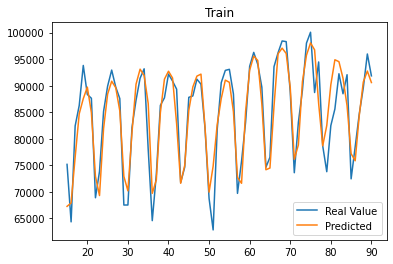

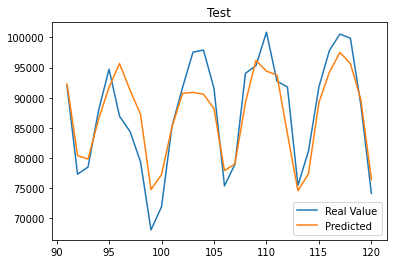

In [20]:
prediction_visualization(train_df, test_df, train_prediction_df, test_prediction_df)

### Evaluation

In [21]:
def evaluate(metric, metric_name, true_values, predicted_values):
    print(f'{metric_name} : {metric(true_values, predicted_values)}')

In [22]:
def evaluation(model_name, train_df, test_df, train_prediction_df, test_prediction_df):
    print(f'{model_name} train scores:')

    evaluate(mean_absolute_error, 'MAE', train_df['Demand'], train_prediction_df)
    evaluate(mean_squared_error, 'MSE', train_df['Demand'], train_prediction_df)
    evaluate(mean_absolute_percentage_error, 'MAPE', train_df['Demand'], train_prediction_df)

    print(f'\n{model_name} test scores:')

    evaluate(mean_absolute_error, 'MAE', test_df['Demand'], test_prediction_df)
    evaluate(mean_squared_error, 'MSE', test_df['Demand'], test_prediction_df)
    evaluate(mean_absolute_percentage_error, 'MAPE', test_df['Demand'], test_prediction_df)


In [23]:
evaluation('Ridge Regression', train_df, test_df, train_prediction_df, test_prediction_df)

Ridge Regression train scores:
MAE : 8.73587485120932
MSE : 179.01141108411136
MAPE : 0.19964511580252303

Ridge Regression test scores:
MAE : 8.874725139805644
MSE : 178.05622753636817
MAPE : 0.19264364123762687


# File Saving

In [24]:
def save_predictions(dataset, path):
    dataset.to_parquet(path, index=False)

In [25]:
def prediction_labeling(pred_df, labeled_df):
    pred_df = pd.DataFrame(pred_df, columns = ['Predicted_demand'])
    labeled_df.reset_index(inplace = True)
    labeled_prediction_df = labeled_df[['PULocation', 'Date', 'DOLocation']]
    labeled_prediction_df['Predicted_demand'] = pred_df
    return labeled_prediction_df

In [26]:
labeled_test_prediction_df = prediction_labeling(test_prediction_df, test_df)
labeled_train_prediction_df = prediction_labeling(train_prediction_df, train_df)

C:\Users\NPC\AppData\Local\Temp\ipykernel_9360\3058505207.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labeled_prediction_df['Predicted_demand'] = pred_df
C:\Users\NPC\AppData\Local\Temp\ipykernel_9360\3058505207.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labeled_prediction_df['Predicted_demand'] = pred_df


In [27]:
print(f'labeled prediction dataframe shape : {labeled_train_prediction_df.shape}')
labeled_train_prediction_df.head()

labeled prediction dataframe shape : (109668, 4)


,PULocation,Date,DOLocation,Predicted_demand
0,13,2023-01-15,68,21.475281
1,13,2023-01-16,68,22.627233
2,13,2023-01-17,68,24.706275
3,13,2023-01-18,68,28.056815
4,13,2023-01-19,68,23.941366


In [28]:
print(f'labeled prediction dataframe shape : {labeled_test_prediction_df.shape}')
labeled_test_prediction_df.head()

labeled prediction dataframe shape : (43290, 4)


,PULocation,Date,DOLocation,Predicted_demand
0,13,2023-04-01,68,22.153462
1,13,2023-04-02,68,18.887359
2,13,2023-04-03,68,23.965120
3,13,2023-04-04,68,33.974492
4,13,2023-04-05,68,33.842866


In [29]:
save_predictions(labeled_train_prediction_df, OUTPUT_PATH_TRAIN)
save_predictions(labeled_test_prediction_df, OUTPUT_PATH_TEST)